In [204]:
import pandas as pd
import pycountry
import pycountry_convert as pc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# checking for null values
data = pd.read_csv('country_vaccinations.csv')
data.isna().any().sum()

9

In [205]:
country_wise = data.groupby("country")

In [206]:
data["country"].nunique()

223

In [207]:
data['date'] = pd.to_datetime(data['date'])

In [208]:
# finding countries with maximum and minimum vaccinated percentages
data.dropna(subset = 'people_fully_vaccinated_per_hundred',inplace = True)
fully_vaxxed = data[['country','date','people_fully_vaccinated_per_hundred']]
indices = fully_vaxxed.groupby('country')['people_fully_vaccinated_per_hundred'].idxmax()
new_indices_max = fully_vaxxed.loc[indices]
max_idx = new_indices_max['people_fully_vaccinated_per_hundred'].idxmax()
max_country = new_indices_max.loc[max_idx]
print(max_country)
new_indices_min = fully_vaxxed.loc[indices]
min_idx = new_indices_min['people_fully_vaccinated_per_hundred'].idxmin()
min_country = new_indices_min.loc[min_idx]
print(min_country)

country                                          Gibraltar
date                                   2022-03-24 00:00:00
people_fully_vaccinated_per_hundred                 122.37
Name: 30235, dtype: object
country                                            Burundi
date                                   2022-03-12 00:00:00
people_fully_vaccinated_per_hundred                   0.08
Name: 12638, dtype: object


In [209]:
# getting top 10% and bottom 10% countries
new_indices = pd.DataFrame(new_indices_max)
sorted = new_indices.sort_values(by='people_fully_vaccinated_per_hundred', ascending = False).head(23)
print(sorted)
print(sorted['country'])

                    country       date  people_fully_vaccinated_per_hundred
30235             Gibraltar 2022-03-24                               122.37
62293              Pitcairn 2021-09-07                               100.00
81914  United Arab Emirates 2022-03-27                                96.12
63189              Portugal 2022-03-10                                92.60
11745                Brunei 2022-03-18                                91.71
70228             Singapore 2022-03-28                                91.04
49111                 Malta 2022-03-28                                90.35
15755                 Chile 2022-03-22                                90.29
63647                 Qatar 2022-03-24                                88.50
14701        Cayman Islands 2022-03-25                                87.80
57358                  Niue 2022-03-13                                87.79
19243                  Cuba 2022-03-27                                87.57
72972       

In [210]:
print((new_indices).head())

          country       date  people_fully_vaccinated_per_hundred
393   Afghanistan 2022-03-22                                11.10
832       Albania 2022-03-24                                42.30
1237      Algeria 2022-03-09                                13.70
1650      Andorra 2022-03-13                                68.99
2040       Angola 2022-03-25                                17.66


In [211]:
# imtegrating continent data
def get_cont(country_name):
    try:
        country_alpha2 = pycountry.countries.lookup(country_name).alpha_2
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except (LookupError, KeyError):
        return None

In [212]:
# adding continent list as a column
cont_list = []
for country in new_indices['country']:
    continent = get_cont(country)
    cont_list.append(continent)


In [213]:
new_indices['continent'] = cont_list
print(new_indices.head())

          country       date  people_fully_vaccinated_per_hundred continent
393   Afghanistan 2022-03-22                                11.10      Asia
832       Albania 2022-03-24                                42.30    Europe
1237      Algeria 2022-03-09                                13.70    Africa
1650      Andorra 2022-03-13                                68.99    Europe
2040       Angola 2022-03-25                                17.66    Africa


In [214]:
# getting mean vaccination rates for all continents
cont_vacc =new_indices.groupby('continent')['people_fully_vaccinated_per_hundred'].mean().reset_index()
print(cont_vacc)

       continent  people_fully_vaccinated_per_hundred
0         Africa                            21.062400
1           Asia                            58.768261
2         Europe                            66.505652
3  North America                            54.918710
4        Oceania                            58.877647
5  South America                            64.871667


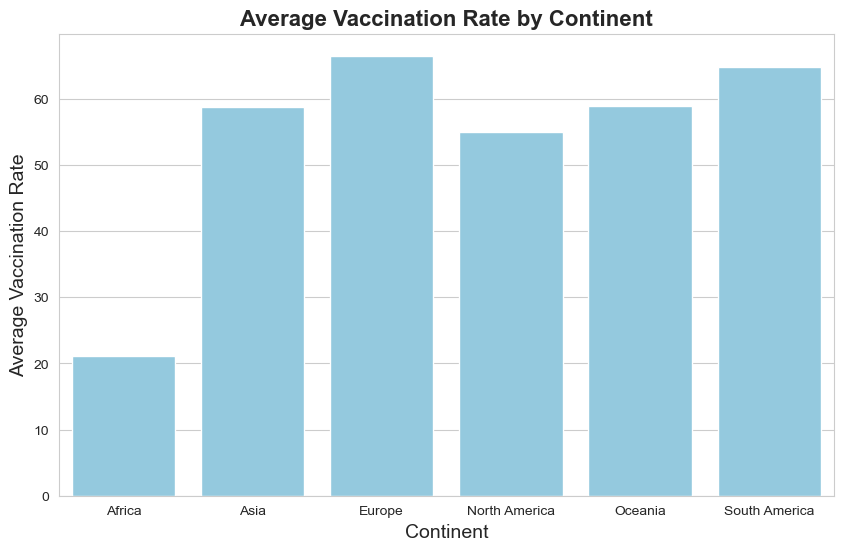

In [215]:
# graph creation
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(data=cont_vacc,x='continent',y='people_fully_vaccinated_per_hundred',color = 'skyblue')
plt.title('Average Vaccination Rate by Continent', fontsize = 16, fontweight = 'bold')
plt.xlabel('Continent', fontsize = 14)
plt.ylabel('Average Vaccination Rate', fontsize = 14)
plt.show()

In [216]:
# integrating population data
pop = pd.read_csv('populations.csv', skiprows = 4)
print(pop.head())
poplist = []
count1 = 0
count2 = 0
for country in new_indices['country']:
    if country in pop['Country Name'].values:
        index = pop[pop['Country Name'] == country].index[0]
        poplist.append(pop.at[index, '2022'])
    else:
        poplist.append(float('nan'))

                  Country Name         2022
0                        Aruba     106445.0
1  Africa Eastern and Southern  720859132.0
2                  Afghanistan   41128771.0
3   Africa Western and Central  490330870.0
4                       Angola   35588987.0


In [217]:
# setting column as poplist, cleaning data again
new_indices['population'] = poplist
cleaned_pop = new_indices[new_indices['population'].notna()]
cleaned_pop['population'].isna().any().sum()

0

In [218]:
# scatterplot showing trends between population distribution and vaccination rate
bins = [0, 20, 40, 60, 80, 100]
bin_labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
cleaned_pop = pd.DataFrame(cleaned_pop)
cleaned_pop['Vacc Range'] = pd.cut(cleaned_pop['people_fully_vaccinated_per_hundred'], bins=bins, labels=bin_labels)
cleaned_pop.head()

,country,date,people_fully_vaccinated_per_hundred,continent,population,Vacc Range
393,Afghanistan,2022-03-22,11.10,Asia,41128771.0,0-20%
832,Albania,2022-03-24,42.30,Europe,2777689.0,40-60%
1237,Algeria,2022-03-09,13.70,Africa,44903225.0,0-20%
1650,Andorra,2022-03-13,68.99,Europe,79824.0,60-80%
2040,Angola,2022-03-25,17.66,Africa,35588987.0,0-20%


In [219]:
grouped = cleaned_pop.groupby('Vacc Range')['country'].count().reset_index()
grouped.columns = ['Vacc Range', 'Number of Countries']
print(grouped)

  Vacc Range  Number of Countries
0      0-20%                   39
1     20-40%                   19
2     40-60%                   39
3     60-80%                   63
4    80-100%                   18


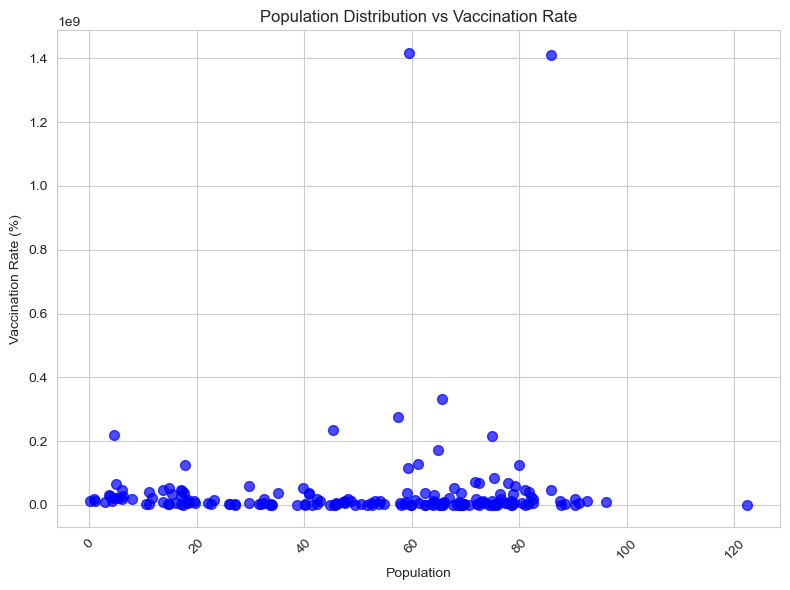

In [220]:
cleaned_pop['Vacc Range'] = cleaned_pop['Vacc Range'].astype(str)
plt.figure(figsize=(8, 6))
plt.scatter(cleaned_pop['people_fully_vaccinated_per_hundred'], cleaned_pop['population'], s=50, c='blue', alpha=0.7)
plt.title('Population Distribution vs Vaccination Rate')
plt.xlabel('Population')
plt.ylabel('Vaccination Rate (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [221]:
# Adding population to data
poplist2 = []
count1 = 0
count2 = 0
for country in data['country']:
    if country in pop['Country Name'].values:
        index = pop[pop['Country Name'] == country].index[0]
        poplist2.append(pop.at[index, '2022'])
    else:
        poplist2.append(float('nan'))
data['population'] = poplist2
print(data.head())

        country iso_code       date  total_vaccinations  people_vaccinated  \
78  Afghanistan      AFG 2021-05-11            504502.0           448878.0   
87  Afghanistan      AFG 2021-05-20            547901.0           470341.0   
91  Afghanistan      AFG 2021-05-24            573277.0           476367.0   
93  Afghanistan      AFG 2021-05-26            590454.0           479372.0   
94  Afghanistan      AFG 2021-05-27            593313.0           479574.0   

    people_fully_vaccinated  daily_vaccinations_raw  daily_vaccinations  \
78                  55624.0                     NaN             13921.0   
87                  77560.0                     NaN              4822.0   
91                  96910.0                     NaN              5692.0   
93                 111082.0                     NaN              6768.0   
94                 113739.0                  2859.0              6487.0   

    total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
78         

In [222]:
# Adding column for number of days since start
data.sort_values(['country', 'date'], inplace=True)
data['Start_Date'] = data.groupby('country')['date'].transform('min')
data['Days Since Start'] = (data['date'] - data['Start_Date']).dt.days
data.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,population,Start_Date,Days Since Start
78,Afghanistan,AFG,2021-05-11,504502.0,448878.0,55624.0,NaN,13921.0,1.27,1.13,0.14,349.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/,41128771.0,2021-05-11,0
87,Afghanistan,AFG,2021-05-20,547901.0,470341.0,77560.0,NaN,4822.0,1.38,1.18,0.19,121.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/,41128771.0,2021-05-11,9
91,Afghanistan,AFG,2021-05-24,573277.0,476367.0,96910.0,NaN,5692.0,1.44,1.20,0.24,143.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/,41128771.0,2021-05-11,13
93,Afghanistan,AFG,2021-05-26,590454.0,479372.0,111082.0,NaN,6768.0,1.48,1.20,0.28,170.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/,41128771.0,2021-05-11,15
94,Afghanistan,AFG,2021-05-27,593313.0,479574.0,113739.0,2859.0,6487.0,1.49,1.20,0.29,163.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/,41128771.0,2021-05-11,16


In [223]:
data = data.interpolate(method='ffill')
data['Percentage Fully Vaccinated'] = (data['people_fully_vaccinated_per_hundred'] / data['population']) * 100
monthly_data = data.resample('M', on='date').mean()
features = ['Days Since Start','daily_vaccinations','people_fully_vaccinated','people_vaccinated_per_hundred','people_vaccinated','people_fully_vaccinated_per_hundred', 'population']
data['Target'] = (0.7 * data['population'] - data['people_fully_vaccinated']) / data['daily_vaccinations']
data.dropna(subset=['Target'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

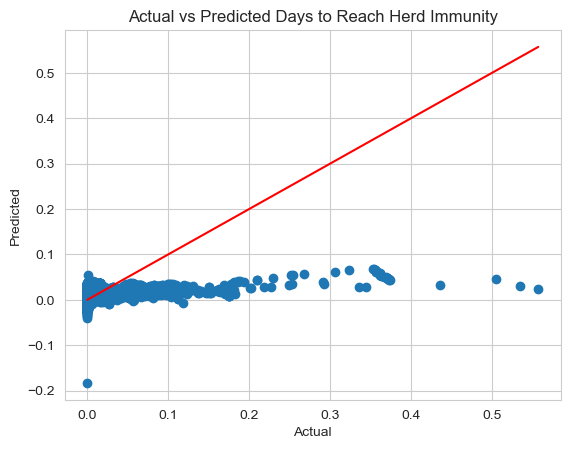

In [224]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Days to Reach Herd Immunity')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

In [ ]:
# Random Forest Aggressor
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Model Performance:")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-squared (R2): {r2_rf}")
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # y=x line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Days to Reach Herd Immunity (Random Forest)')
plt.grid(True)
plt.show()